# Start the Forcing Files : Rivers #

In [27]:
import arrow
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
year = '2017'
month = '01'
day = '01'

In [17]:
single = xr.open_dataset(f'/home/sallen/MEOPAR/tools/I_ForcingFiles/Rivers/ncfiles/R202108Dailies_y{year}m{month}d{day}.nc')
print (single.rorunoff)
single

<xarray.DataArray 'rorunoff' (time_counter: 1, y: 898, x: 398)>
[357404 values with dtype=float64]
Coordinates:
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * time_counter  (time_counter) int64 0
Attributes:
    units:      kg m-2 s-1
    long_name:  runoff_flux


<xarray.Dataset>
Dimensions:       (time_counter: 1, x: 398, y: 898)
Coordinates:
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * time_counter  (time_counter) int64 0
Data variables:
    rorunoff      (time_counter, y, x) float64 ...
Attributes:
    acknowledgements:      Based on river fit
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 Rivers for y2017m01d01
    notebook:              MakeDailyRiverNCfiles.ipynb
    rivers_base:           river_202108
    summary:               Daily Runoff for Bathymetry 202108
    history:               [2021-08-24] File creation.

In [6]:
xsize = 2*single.x.shape[0]
ysize = 2*single.y.shape[0]

In [18]:
def duplicate_copy(single, ysize, xsize):
    double = np.zeros((ysize, xsize))
    double[0::2, 0::2] = single[:]
    double[1::2, 0::2] = single[:] 
    double[0::2, 1::2] = single[:]
    double[1::2, 1::2] = single[:] 
    return double

In [19]:
rorunoff = np.expand_dims(duplicate_copy(single.rorunoff[0], ysize, xsize), axis=0)

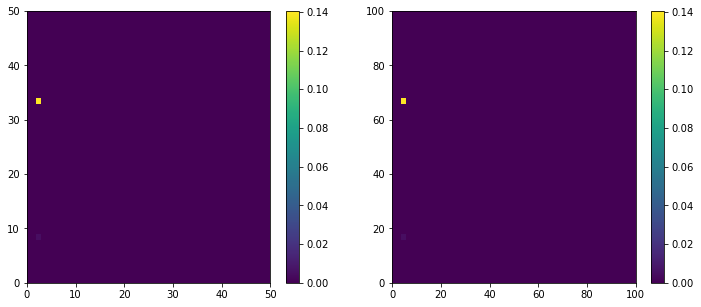

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colours = axs[0].pcolormesh(single.rorunoff[0, 200:250, 200:250])
fig.colorbar(colours, ax=axs[0])
colours = axs[1].pcolormesh(rorunoff[0, 400:500, 400:500]);
fig.colorbar(colours, ax=axs[1]);

In [35]:
def write_the_file(year, month, day, rorunoff, single):
    filename = f'ncfiles/rivers/D202206Dailies_y{year}m{month:02d}d{day:02d}.nc'
  # Add some global attributes
    ds_attrs = {
    'acknowledgements':
        'from 202108 rivers',
    'creator_email':
        'sallen@eoas.ubc.ca',
    'creator_name':
        'Salish Sea MEOPAR Project Contributors',
    'creator_url':
        'https://salishsea-meopar-docs.readthedocs.org/',
    'institution':
        'UBC EOAS',
    'institution_fullname': (
        'Earth, Ocean & Atmospheric Sciences,'
        ' University of British Columbia'
    ),
    'summary': (
        'River file, doubled by copying from 202108 rivers'
    ),
    'source': (
        'tools/double_resolution/rivers.ipynb'
    ),
    'history': (
        '[{}] File creation.'
        .format(datetime.datetime.today().strftime('%Y-%m-%d'))
    )
    }  

    da = {}
    interpl = {
    'rorunoff': rorunoff
    }
    for var in interpl.keys():
        if var == 'nav_lat' or var == 'nav_lon' or var == 'Bathymetry':
            dims = ('y', 'x')
            coords = {'y': np.arange(ysize), 'x': np.arange(xsize)}
        else:
            dims = ('time', 'y', 'x')
            coords = {'time': [0], 'y': np.arange(ysize), 'x': np.arange(xsize)}
        if var == 'rorunoff':
            attrs = single.rorunoff.attrs
        else:
            attrs = ""
        da[var] = xr.DataArray(
            data=interpl[var],
            name=var,
            dims=dims,
            coords=coords,
            attrs=attrs
        )
    ds = xr.Dataset(
    data_vars=da,
    coords=coords,
    attrs=ds_attrs
    )
    encoding = {var: {'zlib': True} for var in ds.data_vars}
    ds.to_netcdf(
    path=filename,
    unlimited_dims=('time'),
    encoding=encoding,
    )

In [26]:
write_the_file(year, month, day, rorunoff, single)

## Now do the Looping over the Year

In [56]:
year = 2017
smonth = 1
emonth = 12
startdate = arrow.get(year, smonth, 1)
enddate = arrow.get(year, emonth, 31)
print (startdate, enddate)

2017-01-01T00:00:00+00:00 2017-12-31T00:00:00+00:00


In [57]:
for day in arrow.Arrow.range('day', startdate, enddate):
    singlefile = f'/home/sallen/MEOPAR/tools/I_ForcingFiles/Rivers/ncfiles/R202108Dailies_y{day.year}m{day.month:02d}d{day.day:02d}.nc'
    single = xr.open_dataset(singlefile)
    
    xsize = 2*single.x.shape[0]
    ysize = 2*single.y.shape[0]
    rorunoff = np.expand_dims(duplicate_copy(single.rorunoff[0], ysize, xsize), axis=0)    
    write_the_file(day.year, day.month, day.day, rorunoff, single)
    
    single.close()
    

## Open and Look

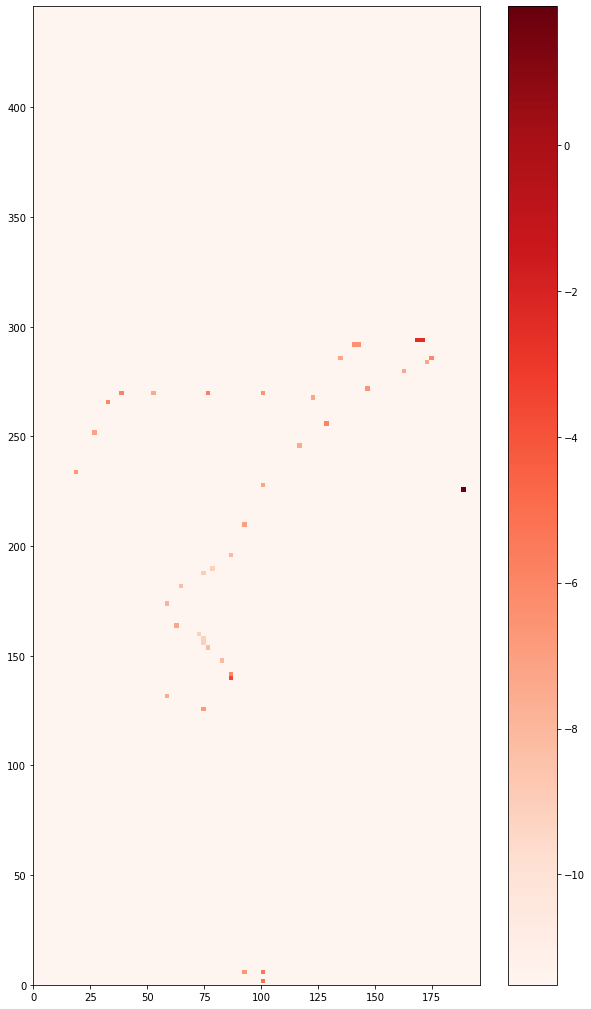

In [54]:
checkit = xr.open_dataset('ncfiles/rivers/D202206Dailies_y2017m01d05.nc')
fig, ax = plt.subplots(1, 1, figsize=(10, 18))
colours = ax.pcolormesh(np.log(checkit.rorunoff[0, 675+100:-675+100, 600:]+0.00001), cmap='Reds')
fig.colorbar(colours, ax=ax);

In [55]:
checkit.close()